# Information About the Dataset

    1) CRIM: per capita crime rate by town
    2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
    3) INDUS: proportion of non-retail business acres per town
    4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
    6) RM: average number of rooms per dwelling
    7) AGE: proportion of owner-occupied units built prior to 1940
    8) DIS: weighted distances to five Boston employment centres
    9) RAD: index of accessibility to radial highways
    10) TAX: full-value property-tax rate per $10,000 [$/10k]
    11) PTRATIO: pupil-teacher ratio by town
    12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    13) LSTAT: % lower status of the population

    Output variable:
    1) MEDV: Median value of owner-occupied homes in $1000's [k$]

# Imports

In [309]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
import joblib
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = None

In [2]:
df = pd.read_csv('boston.csv')
housing = df.copy()

# EDA

In [3]:
housing.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [ ]:
housing.info()

In [ ]:
housing.isna().sum()

In [19]:
@interact(bins=40, figsize_y=8)
def dist(bins, figsize_y):
    housing.hist(bins=bins, figsize=(12, figsize_y))
plt.show()

interactive(children=(IntSlider(value=40, description='bins', max=120, min=-40), IntSlider(value=8, descriptio…

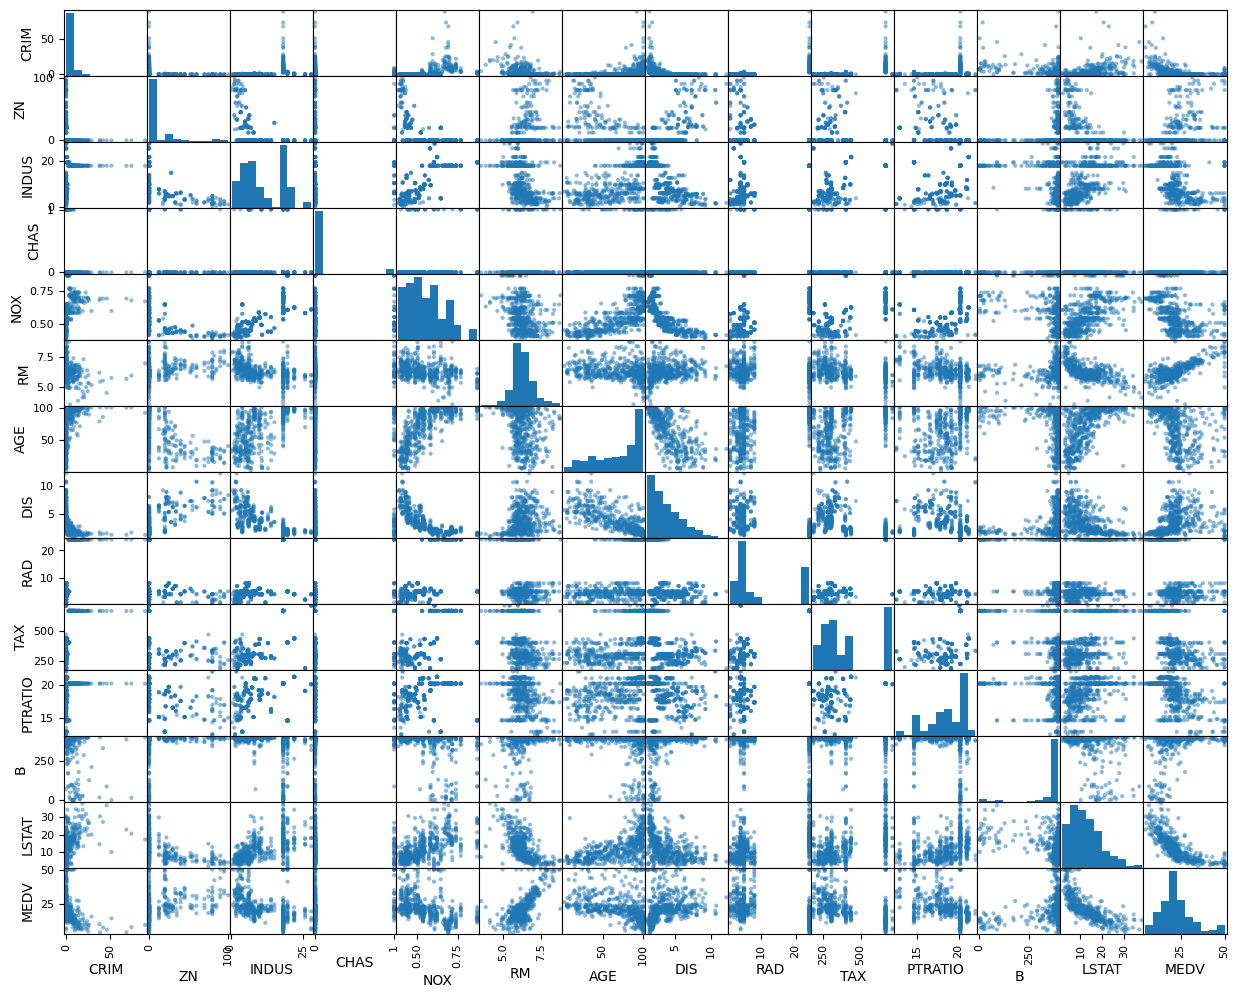

In [7]:
scatter_matrix(housing, figsize=(15, 12))
plt.show()

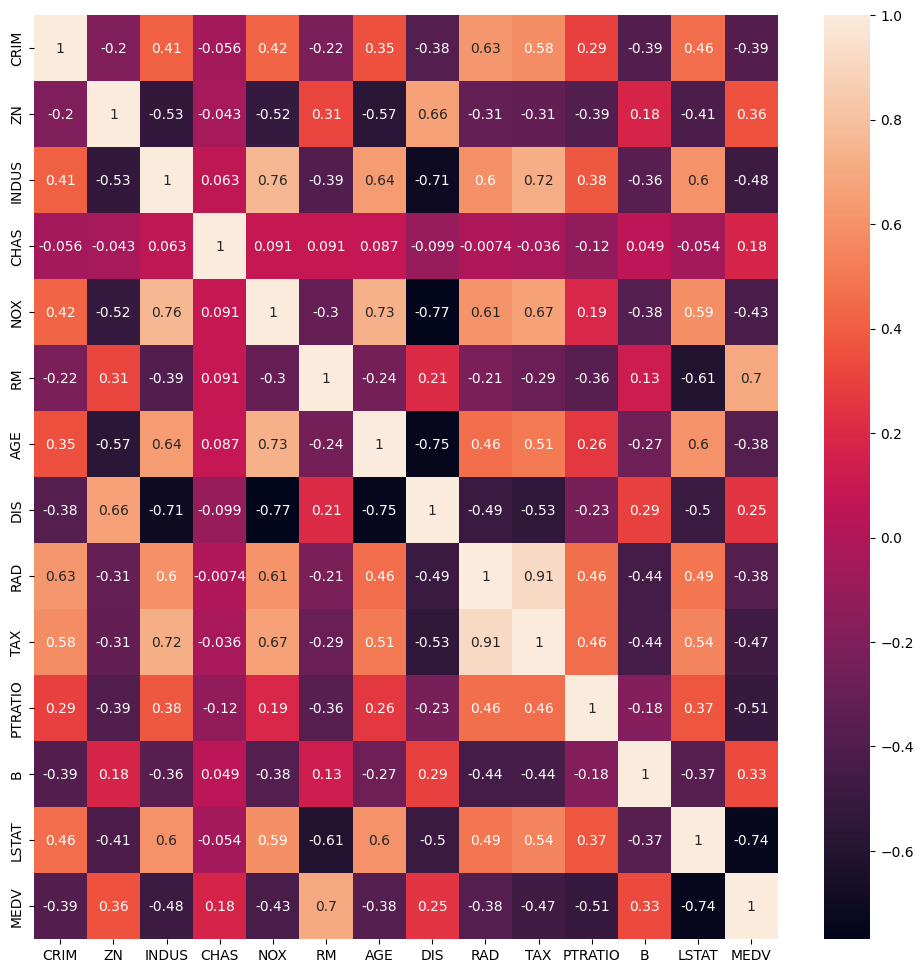

In [8]:
plt.figure(figsize=(12, 12))
corr_mtx = housing.corr()
sns.heatmap(corr_mtx, annot=True)
plt.show()

In [9]:
def high_corr_feats(correlation_matrix, threshold=0.7):
    stacked_corr = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).stack()
    highly_correlated = stacked_corr[abs(stacked_corr) > threshold]
    return highly_correlated

In [10]:
high_corr_feats(corr_mtx, 0.75)

INDUS  NOX    0.763651
NOX    DIS   -0.769230
RAD    TAX    0.910228
dtype: float64

In [11]:
housing_drp_indus = housing.drop(columns=['INDUS'])

# Create Test Set

In [12]:
x_train, x_test, y_train, y_test = train_test_split(housing.drop(columns=['MEDV']),
                                                    housing['MEDV'],
                                                    test_size=0.15,
                                                    random_state=42)

In [13]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((430, 13), (76, 13), (430,), (76,))

# Feature Scaling and Transformation


In [122]:
class BoxCoxTransform(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_np = np.array(X)  # Convert the DataFrame to a NumPy array
        transformed_data = X_np.copy()
        for column in range(X_np.shape[1]):
            transformed_data[:, column], _ = stats.boxcox(X_np[:, column])
        return transformed_data

In [124]:
box_cox_transformer = BoxCoxTransform() # for left skewed data
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp) # for right skewed data
std_scaler = StandardScaler()

In [125]:
transformations = ColumnTransformer([
    ('box_cox', box_cox_transformer, ['AGE', 'B']),
    ('log', log_transformer, ['CRIM', 'DIS', 'LSTAT'])
], 
remainder='passthrough')

In [126]:
preprocessing = make_pipeline(transformations, std_scaler)

In [127]:
housing_prepared = preprocessing.fit_transform(x_train)

In [128]:
housing_prepared_df = pd.DataFrame(housing_prepared, columns=x_train.columns)

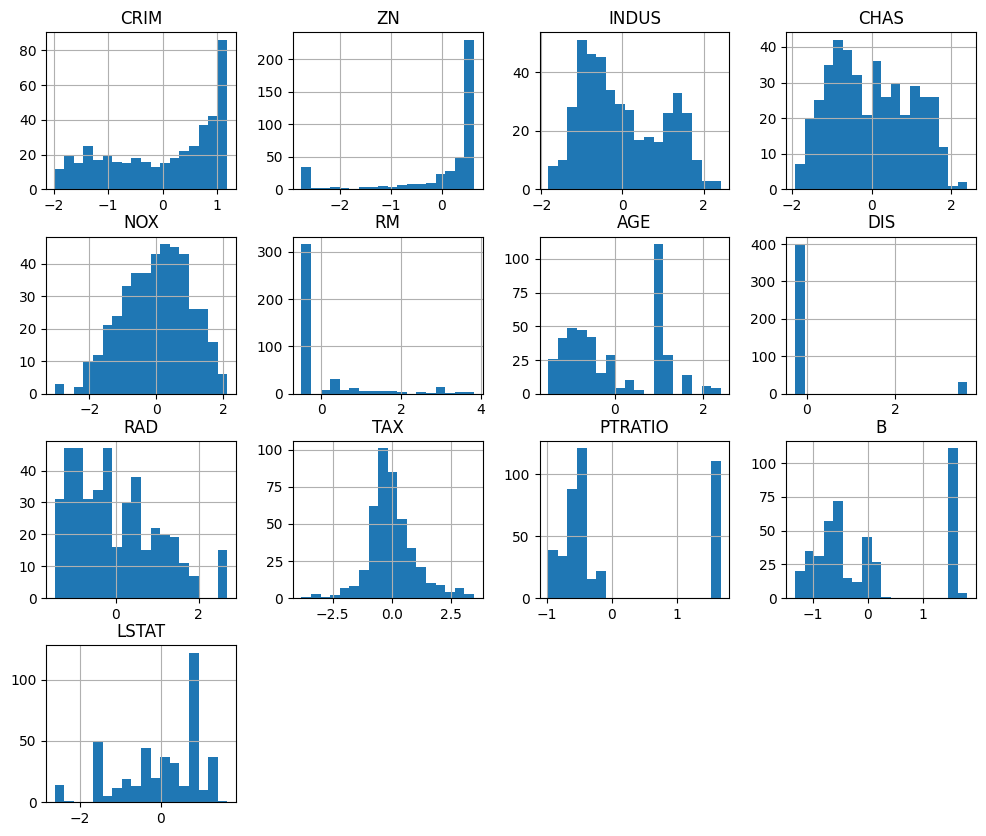

In [129]:
housing_prepared_df.hist(bins=18, figsize=(12, 10))
plt.show()

# Test Different Models

In [175]:
rf = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
rf.fit(x_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('box_cox',
                                                                   BoxCoxTransform(),
                                                                   ['AGE',
                                                                    'B']),
                                                                  ('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>),
                                                                   ['CRIM',
                                                                    'DIS',
                                                                    'LSTAT'])])),
                                 ('standardscaler', StandardScaler())])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [293]:
lgb = lgbm.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    metric='rmse',
    num_leaves=31,
    learning_rate=0.05,
    num_round=100
)

lgb_pl = make_pipeline(preprocessing, lgb)
lgb_pl.fit(x_train, y_train)

[LightGBM] [Warning] num_iterations is set=100, num_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 430, number of used features: 13
[LightGBM] [Info] Start training from score 22.689302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('box_cox',
                                                                   BoxCoxTransform(),
                                                                   ['AGE',
                                                                    'B']),
                                                                  ('log',
                                                                   FunctionTransformer(func=<ufunc 'log'>,
                                                                                       inverse_func=<ufunc 'exp'>),
                                                                   ['CRIM',
                                                                    'DIS',
                                                                    'LSTAT'])])),
                                 ('standardscaler', StandardScaler())])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.05, metric='rmse', num_round=100,
                               objective='regression'))])

In [182]:
rf_score = rf.score(x_train, y_train)
rf_predictions = rf.predict(x_train)
rf_rmse = mean_squared_error(y_train, rf_predictions, squared=False)
rf_rmses = -cross_val_score(rf, x_train, y_train,
                               scoring='neg_root_mean_squared_error', cv=15)

In [294]:
lgb_score = lgb_pl.score(x_train, y_train)
lgb_predictions = lgb_pl.predict(x_train)
lgb_rmse = mean_squared_error(y_train, lgb_predictions, squared=False)
lgb_rmses = -cross_val_score(lgb_pl, x_train, y_train,
                               scoring='neg_root_mean_squared_error', cv=15)

[LightGBM] [Warning] num_iterations is set=100, num_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 401, number of used features: 13
[LightGBM] [Info] Start training from score 22.839152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [183]:
print(rf_score, rf_rmse)

0.9791438501325371 1.3519358979230576


In [295]:
print(lgb_score, lgb_rmse)

0.9521151512729698 2.0485100098974405


In [184]:
pd.Series(rf_rmses).describe()

count    13.000000
mean      3.349417
std       0.759294
min       1.811971
25%       2.921815
50%       3.410317
75%       4.030941
max       4.489982
dtype: float64

In [300]:
pd.Series(lgb_rmses).describe()

count    15.000000
mean      3.607407
std       1.046108
min       2.061338
25%       2.958338
50%       3.259457
75%       4.055860
max       5.782773
dtype: float64

# Hyperparameter Tuning

In [316]:
lgb_model = lgbm.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    metric='rmse',
    random_state=42,
    verbose=-1
)

In [317]:
full_pl = Pipeline([
    ('preprocessing', preprocessing),
    ('lgbm', lgb_model)
])

In [318]:
param_grid = {
    'lgbm__n_estimators': [70, 80],
    'lgbm__max_depth': [5, 10],
    'lgbm__learning_rate': [0.01, 0.1],
    'lgbm__min_samples_leaf': [4, 8],
    'lgbm__reg_lambda ': [0, 0.1]
}

grid_search = GridSearchCV(estimator=full_pl, param_grid=param_grid, 
                           cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('box_cox',
                                                                                          BoxCoxTransform(),
                                                                                          ['AGE',
                                                                                           'B']),
                                                                                         ('log',
                                                                                          FunctionTransformer(func=<ufunc 'log'>,
                                                                                                              inverse_func=<ufunc 'exp'>),
                                                                                          ['CRIM',
                                                                                           'DIS',
                                                                                           'LSTAT'])])),
                                                        ('standardscaler',
                                                         StandardScaler())])),
                                       ('lgbm',
                                        LGBMRegressor(metric='rmse',
                                                      objective='regression',
                                                      random_state=42,
                                                      verbose=-1))]),
             n_jobs=-1,
             param_grid={'lgbm__learning_rate': [0.01, 0.1],
                         'lgbm__max_depth': [5, 10],
                         'lgbm__min_samples_leaf': [4, 8],
                         'lgbm__n_estimators': [70, 80],
                         'lgbm__reg_lambda ': [0, 0.1]},
             scoring='neg_root_mean_squared_error')

In [319]:
-grid_search.best_score_, grid_search.best_params_

(3.326193252171534,
 {'lgbm__learning_rate': 0.1,
  'lgbm__max_depth': 5,
  'lgbm__min_samples_leaf': 4,
  'lgbm__n_estimators': 80,
  'lgbm__reg_lambda ': 0})

In [320]:
final_estimator = grid_search.best_estimator_

# Evaluate on Test Set

In [321]:
final_predictions = final_estimator.predict(x_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

2.259711824554429


In [322]:
final_estimator.score(x_test, y_test)

0.9218070489480246

# Save the Model

In [323]:
joblib.dump(final_estimator, 'boston_housing_model.pkl')

['boston_housing_model.pkl']